In [58]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

parms = {}

# store all data here
class atomXsFs:
    def __init__(self,numAtoms,numTurns):
        # for each atom, at every turn, we have xpos, ypos, zpos, xforce, yforce, zforce data points (6 data points)
        self.dat = np.zeros((numAtoms, numTurns, 6))
        
    def addData(self,atomID,turn, xpos, ypos, zpos, xforce, yforce, zforce):
        self.dat[atomID,turn,0:] = xpos,ypos,zpos,xforce,yforce,zforce
        # add the data to the given array

iline = 0
thisFile = open("resultsFixWallHarmonic.txt", "r")

# open the file and assign relevant parameters
print "loading parameters"
for line in thisFile:
    iline +=1
    thisLine = line.split()
    if thisLine[0] == "REMARK":
        parms[str(thisLine[1])]= str(thisLine[2])
    
    # and now we are done reading remarks
    if thisLine[0] != "REMARK":
        break
        
print "parameters loaded"
# return to beginning of file
            
print "loading atom coords and forces"

# instantiate the class
print parms
nAtoms = int(parms['maxAtomID']) - int(parms['minAtomID']) + 1

myAtoms = atomXsFs(nAtoms,int(parms['nTurns']))

# this does not assume that atoms are written in any particular order; it assumes 
# that they are completely out of order 

for i in range(int(nAtoms)):
    turn = 0
    thisFile.seek(0,0)
    for line in thisFile:
        thisLine = line.split()
        if thisLine[0] == "REMARK":
            continue
        elif thisLine[0] == "Turn":
            # check if we are done
            if str(thisLine[1]) == str(parms['nTurns']):
                continue
            else:
                continue
        elif (str(thisLine[0])==str(i)):
            thisAtom = int(i)
            posx = float(thisLine[1])
            posy = float(thisLine[2])
            posz = float(thisLine[3])
            forcex = float(thisLine[4])
            forcey = float(thisLine[5])
            forcez = float(thisLine[6])
            myAtoms.addData(thisAtom, turn, posx, posy, posz, forcex, forcey, forcez)
            turn +=1                
        else:
            continue

thisFile.close()
print "atom coords and forces loaded"


loading parameters
parameters loaded
loading atom coords and forces
{'springConstant': '2.257', 'maxAtomID': '4', 'minAtomID': '0', 'nTurns': '5000', 'boxlength': '60', 'FixWallType': 'HARMONIC', 'cutoff': '29'}
atom coords and forces loaded


In [51]:
# accesses atom index 1's (the second atom) data for turn 10,000 (which is stored in index 9999, or -1)
#print myAtoms.dat[3,:,:]
# for fun

# Considerations for future:
## - implement a distance function, compute distances from wall, store these distances rather than the coordinates (ties in to second point)
## - import data regarding the wall plane rather than having it only in the input file script (makes this validation more self-contained)

2.257 spring constant
29.0 cutoff distance


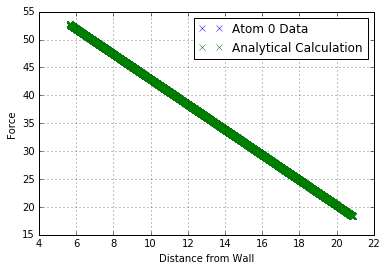

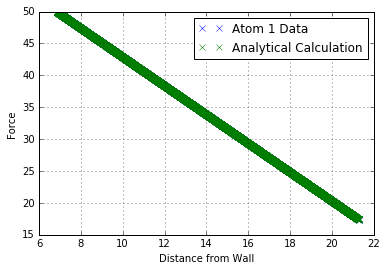

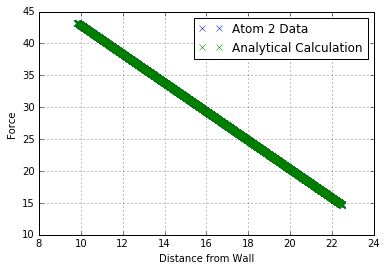

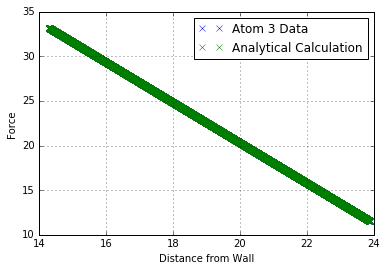

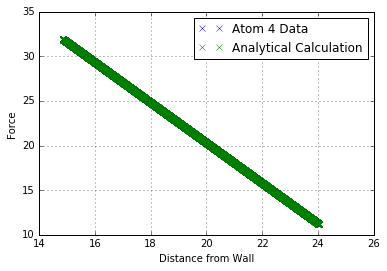

In [60]:
# graph the points
# np is zero 

#initialize a counter for figures

# at the moment, it suffices to plot the particle distance as the xposition, since the wall is the yz-plane at x=0
numFigs = 1
# analytical force function LJ: 
def forceLJ(distance):
    ljForce = np.zeros(len(distance))
    eps = float(parms['epsilon'])
    sigma = float(parms['sigma'])
    sigma6 = sigma**6
    sigma12 = sigma**12
    
    invDist = np.zeros(len(distance))
    invDist6 = np.zeros(len(distance))
    invDist12 = np.zeros(len(distance))
    
    for index, item in enumerate(distance):
        invDist[index] = 1./float(distance[index])
        invDist6[index] = invDist[index] ** 6
        invDist12[index] = invDist6[index] ** 2
        
    for index, item in enumerate(distance):
        if (float(parms['cutoff']) <= item):
            ljForce[index] = 0.0
        else:
            ljForce[index] = 24*eps*(sigma6*invDist6[index] - sigma12*invDist12[index]) * invDist[index]
    return ljForce

print float(parms['springConstant']), "spring constant"
print float(parms['cutoff']), "cutoff distance"

def forceSpring(distance):
    springForce = np.zeros(len(distance))
    for index,item in enumerate(distance):
        if (float(parms['cutoff']) <= item):
            springForce[index] = 0.0
        else:
            springForce[index] = float(parms['springConstant']) * (float(parms['cutoff']) - item)
    return springForce

for atom in range(nAtoms):
    plt.figure(numFigs)
    xvals = myAtoms.dat[atom,1:,0]
    yvals = myAtoms.dat[atom,1:,3]
    yvals_Spring = forceSpring(xvals)
    plt.plot(xvals,yvals,'x', xvals, yvals_Spring,'x')
    plt.legend(['Atom %d Data' %atom, 'Analytical Calculation'], loc='upper right')
    plt.xlabel('Distance from Wall')
    plt.ylabel('Force')
    plt.grid()
    numFigs = numFigs + 1
    
# also, why are there 2 x's next to each data name in the legend? what is going on here?!

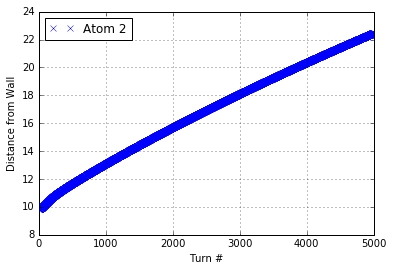

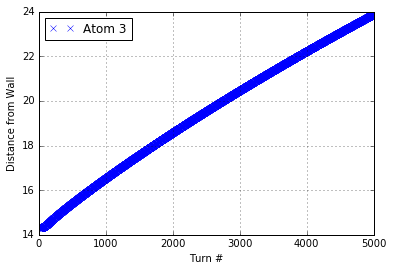

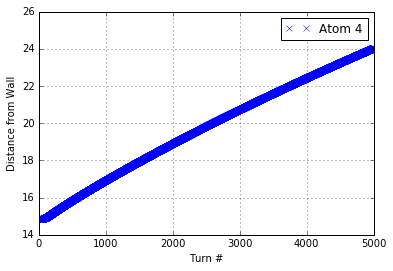

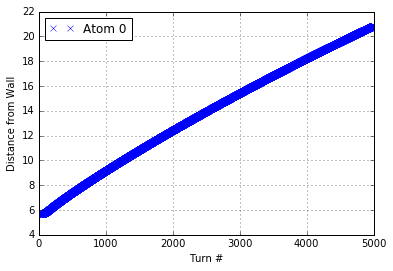

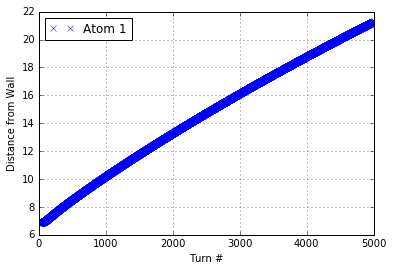

In [61]:
# examine the xpos data as a function of the number of turns

for atom in range(nAtoms):
    plt.figure(numFigs)
    xvals = range(0,int(parms['nTurns']))
    yvals = myAtoms.dat[atom,:,0]
    plt.plot(xvals,yvals,'x')
    plt.legend(['Atom %d' %atom],loc='best')
    plt.xlabel('Turn #')
    plt.ylabel('Distance from Wall')
    plt.grid()
    numFigs = numFigs + 1

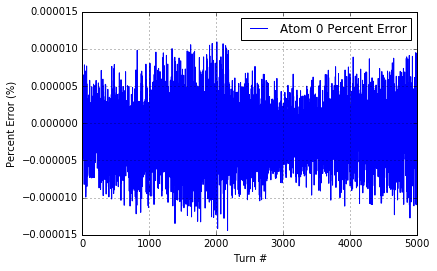

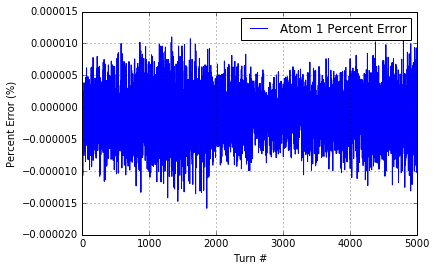

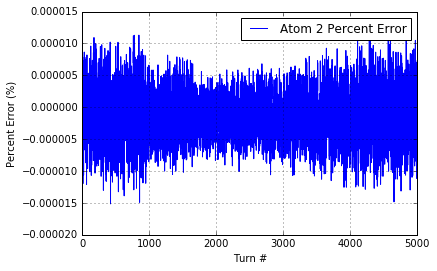

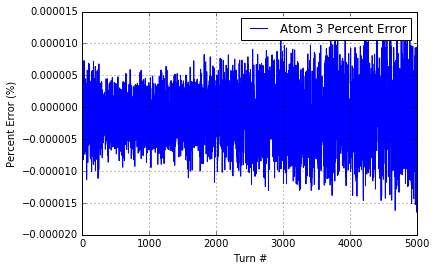

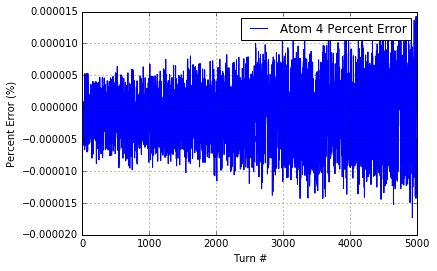

In [63]:
## more importantly, look at the deviations of md_engine wall fix vs analytical results

def percentError(calculated,analytical):
    percentError_ = np.zeros(len(calculated))
    for index, item in enumerate(calculated):
        # leave zeros in the vector if beyond the cutoff distance; otherwise, calculate it (avoids divide by zero)
        if analytical[index]>0.0:
            percentError_[index] = (calculated[index]-analytical[index])/analytical[index] * 100
    return percentError_

for atom in range(nAtoms):
    plt.figure(numFigs)
    xvals = range(1,int(parms['nTurns']))
    yvals = myAtoms.dat[atom,1:,3]
    distFromWall = myAtoms.dat[atom,1:,0]
    yvals_Spring = forceSpring(distFromWall)
    yvals_Error = percentError(yvals,yvals_Spring)
    plt.plot(xvals,yvals_Error)
    plt.legend(['Atom %d Percent Error' %atom], loc='upper right')
    plt.xlabel('Turn #')
    plt.ylabel('Percent Error (%)')
    plt.grid()
    numFigs = numFigs + 1
    
    
## graphs are consistent with numerical error found with single precision